In [43]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from tqdm import tqdm_notebook as tqdm
from shapely.geometry import LineString
from shapely.geometry import Point
from math import radians, cos, sin, asin, sqrt

In [2]:
path='./data/'

In [ ]:
#patp2=pd.read_csv(path+'21-09-2020-30-09-2020.csv',sep='\s+', error_bad_lines=False, skiprows=100001, nrows=1000000, header=None)

In [4]:
patp=pd.read_csv(path+'2020-09-28.csv',sep=',',header=None,skiprows=1)
patp=patp.rename(columns={0: 'MODULEID' , 1:'lat' , 2:'long', 3:'SPEED', 4:'SATCOUNT' , 5:'LOCALEVENTTIME', 6:'data', 7:'time'})
id_gosnomer=pd.read_csv(path+'id-gosnomer.csv', sep='\s+')
patp['lat']=patp['lat'].str.replace(',','.').astype(float)
patp['long']=patp['long'].str.replace(',','.').astype(float)
patp.to_csv(path+'2020-09-28.csv',index=False)

In [11]:
patp_gpd = gpd.GeoDataFrame(patp,  geometry = [Point(xy) for xy in zip(patp['long'], patp['lat'])])
patp_gpd=patp_gpd[['MODULEID','geometry','time']]
patp_gpd.crs='epsg:4326'
patp_gpd.to_file(path+"2020_09_28.json", driver="GeoJSON")

## Вырезаем точки трека,близкие к остановкам для автобусов ПАТП:

In [97]:
# Cчитываем файлы, содержащие треки за 28 сентября 2020 года
df_4 = pd.read_csv(path + '2020-09-30.csv')

# Считываем файл с последовательным списком остановок на маршрутах ('stop_seq.csv')
stop_seq = pd.read_csv(path + 'stop_seq_patp_for_28.csv', sep = ';', encoding = 'utf8')

In [98]:
df_4=df_4.rename(columns={'0': 'MODULEID' , '1':'lat' , '2':'long', '3':'SPEED', '4':'SATCOUNT' , '5':'LOCALEVENTTIME', '6':'data', '7':'time'})

In [99]:
df_4=df_4[['MODULEID','lat','long','data','time']]
df_4['lat']=df_4['lat'].str.replace(',','.').astype(float)
df_4['long']=df_4['long'].str.replace(',','.').astype(float)

In [100]:
df_4_gpd = gpd.GeoDataFrame(df_4,  geometry = [Point(xy) for xy in zip(df_4['long'], df_4['lat'])])
df_4_gpd.crs='epsg:4326'

In [101]:
stop_seq_gpd = gpd.GeoDataFrame(stop_seq,  geometry = [Point(xy) for xy in zip(stop_seq['ss_long'], stop_seq['ss_lat'])])
stop_seq_gpd.crs='epsg:4326'

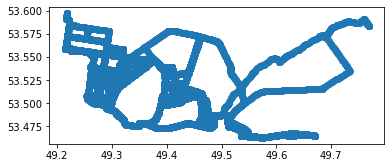

In [102]:
df_4_gpd.plot()

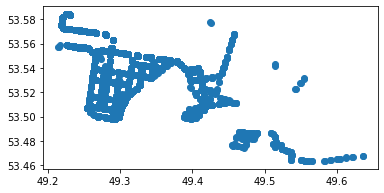

In [103]:
stop_seq_gpd.plot()

In [104]:
#пересекли треки с остановками с буфером 100 метров
stops_with_buff = stop_seq_gpd.to_crs('epsg:32640')
stops_with_buff.geometry = stops_with_buff.geometry.buffer(100)
stops_with_buff = stops_with_buff.to_crs('epsg:4326')
df_4_small=gpd.sjoin(df_4_gpd, stops_with_buff, how='left', op='within', lsuffix='left', rsuffix='right')

In [105]:
df_4_small=df_4_small[df_4_small['ssId'].notna()]

In [106]:
len(df_4_small)

475428

In [107]:
# Расчёт растояния между координатами
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 * 1000 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [108]:
df_4_small['len'] = 0
df_4_small['len'] = df_4_small.apply(lambda row: haversine(row.long, row.lat, row.ss_long, row.ss_lat), axis = 1)

In [130]:
df_4_small['time2']=pd.to_datetime(df_4_small['time'])
df_4_small['hour']=df_4_small['time2'].dt.hour
df_4_small['min']=df_4_small['time2'].dt.minute
df_4_small['sec']=df_4_small['time2'].dt.second
df_4_small['time']=(df_4_small['hour'].astype(int))*3600+(df_4_small['min'].astype(int))*60+df_4_small['sec'].astype(int)

In [110]:
df_4_small2=df_4_small[['mr_id','rl_id','rc_orderby','ssId','MODULEID','time','len','geometry','ss_lat','ss_long','route_number']]

In [111]:
df_4_small2.to_csv('for_perl_patp_2020_09_30.csv',index=False,sep=';')

## Формируем выгрузку для привязки валидаций!

In [284]:
df_4_small3=pd.read_csv('for_perl_patp_2020_09_30.csv',sep=';')

In [285]:
df_4_small3['time2']=pd.to_datetime(df_4_small3['time'])
df_4_small3['hour']=df_4_small3['time2'].dt.hour
df_4_small3['min']=df_4_small3['time2'].dt.minute
df_4_small3['sec']=df_4_small3['time2'].dt.second

In [286]:
df_4_small3['time_in_sec']=(df_4_small3['hour'].astype(int))*3600+(df_4_small3['min'].astype(int))*60+(df_4_small3['sec'].astype(int))

In [287]:
df_4_small3=df_4_small3.sort_values(by=['mr_id','rl_id','MODULEID','time_in_sec','rc_orderby'])

In [288]:
df_4_small3['time_in_sec2']=df_4_small3.groupby(['mr_id','rl_id','MODULEID'])['time_in_sec'].shift(-1).astype('Int64')

Убираем строки, которые идут друг за дружкой с одной и той же остановкой

In [289]:
df_4_small3['rc_orderby2'] = df_4_small3.groupby(['mr_id','rl_id','MODULEID'])['rc_orderby'].shift(-1).astype('Int64')
df_4_part=df_4_small3[~(df_4_small3['rc_orderby2']==df_4_small3['rc_orderby'])]
df_4_part['time_start']=df_4_part['time_in_sec']

<ipython-input-289-aa9a0b545165>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4_part['time_start']=df_4_part['time_in_sec']


In [290]:
df_4_part['time_finish'] = df_4_part.groupby(['mr_id','rl_id','MODULEID'])['time_start'].shift(-1).astype('Int64')

<ipython-input-290-eb3b01c8adde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4_part['time_finish'] = df_4_part.groupby(['mr_id','rl_id','MODULEID'])['time_start'].shift(-1).astype('Int64')


In [291]:
df_4_part=df_4_part[['mr_id','rl_id','MODULEID','rc_orderby','len','ssId','time','len','time_start','time_finish','ss_lat','ss_long','geometry']]

## Выбираем только те последовательности, где между двумя посл. отметками прошло не больше 40 минут

In [292]:
df_4_part['delta']=df_4_part['time_finish']-df_4_part['time_start']
df_4_part['delta2']=df_4_part.groupby(['mr_id','rl_id','MODULEID'])['delta'].shift(1).astype('Int64')
df_4_part=df_4_part[((df_4_part['delta']<60*40)&(df_4_part['delta']>0))|(df_4_part['delta'].isna())].\
append(df_4_part[(df_4_part['delta2']<60*40)&(df_4_part['delta2']>0)]).\
append(df_4_part[df_4_part['rc_orderby']==1]) #добавили конечные (там отстои могут быть очень долго)

df_4_part=df_4_part.sort_values(by=['mr_id','rl_id','MODULEID','time_start','rc_orderby'])

df_4_part=df_4_part[['mr_id','rl_id','MODULEID','rc_orderby','len','ssId','time','len','time_start','time_finish','ss_lat','ss_long','geometry']].drop_duplicates()

In [293]:
df_4_part[(df_4_part['rl_id']==2227623156) & (df_4_part['MODULEID']==8560)]

,mr_id,rl_id,MODULEID,rc_orderby,len,len,ssId,time,len,len,time_start,time_finish,ss_lat,ss_long,geometry


## Выбираем только те последовательности, где номера остановок растут 

In [294]:
len(df_4_part)

2816

In [295]:
df_4_part['rc_orderby2'] = df_4_part.groupby(['mr_id','rl_id','MODULEID'])['rc_orderby'].shift(-1).astype('Int64')
df_4_part=df_4_part[(df_4_part['rc_orderby2']>df_4_part['rc_orderby'])|(df_4_part['rc_orderby2'].isna())]

## Выбираем только те последовательности, где остановок как минимум 50% из последовательности встретилось

In [296]:
df_4_count=pd.DataFrame(df_4_part.groupby(['mr_id','rl_id','MODULEID']).agg({'ssId': pd.Series.nunique}).reset_index())

In [297]:
stop_seq[0:2]

,rc_orderby,ssId,ss_lat,ss_long,rl_id,mr_id,route_number,geometry
0,1,stop__9854427,53.557965,49.228861,2227623047,2227622934,12,POINT (49.22886 53.55796)
1,2,stop__9854425,53.557324,49.236213,2227623047,2227622934,12,POINT (49.23621 53.55732)


In [298]:
stop_seq_count=pd.DataFrame(stop_seq.groupby(['mr_id','rl_id']).agg({'ssId': pd.Series.nunique}).reset_index())

In [299]:
df_4_count=df_4_count.merge(stop_seq_count,on=['mr_id','rl_id'],how='left')

In [300]:
df_4_count=df_4_count.drop_duplicates()

In [301]:
df_4_count['percent']=(df_4_count['ssId_y']-df_4_count['ssId_x'])/df_4_count['ssId_y']

In [302]:
df_4_count=df_4_count[df_4_count['percent']>0.5]

In [303]:
df_4_part=df_4_part.merge(df_4_count,on=['mr_id','rl_id','MODULEID'],how='left')

In [304]:
df_4_part=df_4_part[df_4_part['percent'].notna()]

In [305]:
df_4_part=df_4_part[['mr_id','rl_id','MODULEID','rc_orderby','ssId','time','time_start','time_finish','ss_lat','ss_long','geometry']]

In [306]:
df_4_part.to_csv('res2020_09_30.csv', index=False)